In [17]:
import urllib.request
import pprint as pp
import datetime, pymysql, json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from models import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, and_
import numpy as np
%matplotlib inline



# -*- coding: utf-8 -*--

#검색 기준 시간 돌리려면 주석친부분의 days 부분을 변경해주세요
#검색기준시간 ~ 일주일전으로 검색
with open("config.json", "r", encoding="utf8") as f:
    contents = f.read()
    json_data = json.loads(contents)
    
user = json_data["users"][0]["user"]
password = json_data["users"][0]["password"]
host = json_data["users"][0]["host"]
port = json_data["users"][0]["port"]
kobis_key = json_data["users"][0]["kobis_key"]
DB = json_data["users"][0]["DB"]

engine = create_engine('mysql+pymysql://%s:%s@%s:%s/%s?charset=utf8'%(user,password,host,port,DB))
Session = sessionmaker(bind=engine)
session = Session()

Base = declarative_base()
Base.metadata.create_all(engine)
conn= engine.connect()

#영화명, 관객수, 조회일 크롤링해온다음 디비에 저장시킴, 저장시킨걸 데이터프레임으로 보여줌
def get_movie_audiance_num_per_date(input_date, time_section):
    #params : week or month

    input_date = datetime.datetime.strptime(input_date,'%Y-%m-%d')
    searching_date = []
    
    if not input_date:
        print("오늘날짜 업데이트가 되지 않았어요ㅜㅜ 어제날짜로 검색하시겠습니까?")
    
    while time_section:
        searching_date.append(input_date.strftime("%Y%m%d"))
        input_date -= datetime.timedelta(days=1)
        time_section -= 1


    movie_info_per_date = {}
    for date_time in searching_date:
        base_url = urllib.request.urlopen(f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={kobis_key}&targetDt={date_time}")
        sources = json.load(base_url)
        movie_infos = sources["boxOfficeResult"]['dailyBoxOfficeList']
    
        audiacc_per_movie = {}
        for movie_info in movie_infos:
            audiacc_per_movie[movie_info['movieNm']] = movie_info['audiCnt']
        movie_info_per_date[date_time] = audiacc_per_movie


    movie_table = pd.DataFrame(movie_info_per_date)
    movie_table["sum"] = movie_table.sum(axis = 1)
    movie_table = movie_table.sort_values(by = "sum", ascending= False)[:5]
    del movie_table["sum"]
    
    insert_into_db(movie_table)
    return movie_table

#인섵하는 함수. 헬프함수
def insert_into_db(movie_table):
    movie_table = pd.DataFrame(movie_table).fillna(-1)
    for movie_name, section_audi in zip(movie_table.index, movie_table.values):
        for search_date,today_audi in zip(movie_table.keys(), section_audi):
            search_date = datetime.datetime.strptime(search_date,'%Y%M%d').date()
            if today_audi != -1 : 
                add_movie_info = KobisMovieInfo(movie_name, search_date, today_audi)
                session.merge(add_movie_info)
    session.commit()
            
    return "Inserted Succesfully"


#디비에있는것 그래프로 그려줌
def query_and_draw(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date,'%Y-%M-%d').date()
    end_date = datetime.datetime.strptime(end_date,'%Y-%M-%d').date()
    query = pd.DataFrame(session.query(KobisMovieInfo.movie_name, KobisMovieInfo.search_date,KobisMovieInfo.today_audi).filter(start_date >= KobisMovieInfo.search_date).filter(KobisMovieInfo.search_date >= end_date).all())
    movie_table =  pd.DataFrame(index = list(set(query.movie_name)), columns = sorted(list(set(query.search_date))))
    
    for i in query.values:
        movie_table.loc[movie_table.index == i[0] , movie_table.columns == i[1]] = i[2]
    movie_table["sum"] = movie_table.sum(axis = 1)
    movie_table = movie_table.sort_values(by = "sum", ascending= False)[:5]
    del movie_table["sum"]
    del query
    
    movie_table.columns = movie_table.columns.map(lambda x : x.strftime('%Y%m%d'))
    movie_name = list(movie_table.index)
    date_time = movie_table.columns
    auc_rate = movie_table.values

    plt.figure(figsize = (15,12))
    for i in auc_rate:
        plt.plot(date_time,i, marker = "o")
    plt.xlabel("Date")
    plt.ylabel("AudiAcc")
    plt.autoscale(enable = True, axis = "y")
    
    
    font_name = fm.FontProperties(fname = "./font/NanumGothic.ttf").get_name()
    plt.rc('font', family = font_name)
    plt.legend(movie_name, loc = "best")
    return plt.show()

session.close()

In [15]:
get_movie_audiance_num_per_date('2018-01-30', 15)

/home/hyuna/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/crud.py:700: SAWarning: Column 'KobisMovieInfo.index' is marked as a member of the primary key for table 'KobisMovieInfo', but has no Python-side or server-side default generator indicated, nor does it indicate 'autoincrement=True' or 'nullable=True', and no explicit value is passed.  Primary key columns typically may not store NULL. Note that as of SQLAlchemy 1.1, 'autoincrement=True' must be indicated explicitly for composite (e.g. multicolumn) primary keys if AUTO_INCREMENT/SERIAL/IDENTITY behavior is expected for one of the columns in the primary key. CREATE TABLE statements are impacted by this change as well on most backends.
  util.warn(msg)


,20180116,20180117,20180118,20180119,20180120,20180121,20180122,20180123,20180124,20180125,20180126,20180127,20180128,20180129,20180130
1987,116339,90628,80291,91395,198201,175486,52331,49512,35857,33264,36987,77436,72382,26748,25848
1급기밀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24259,21911,22959,45379,40843,15994,15394
코코,114778,82114,85272,98539,235545,231613,68326,72957,62595,65984,76138,207865,199350,54634,55160
커뮤터,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3035,35006,32942,33446,62288,54826,19287,16663
쥬만지: 새로운 세계,40362,14390,13139,12593,22832,19430,7317,7734,NaN,NaN,NaN,NaN,NaN,NaN,NaN


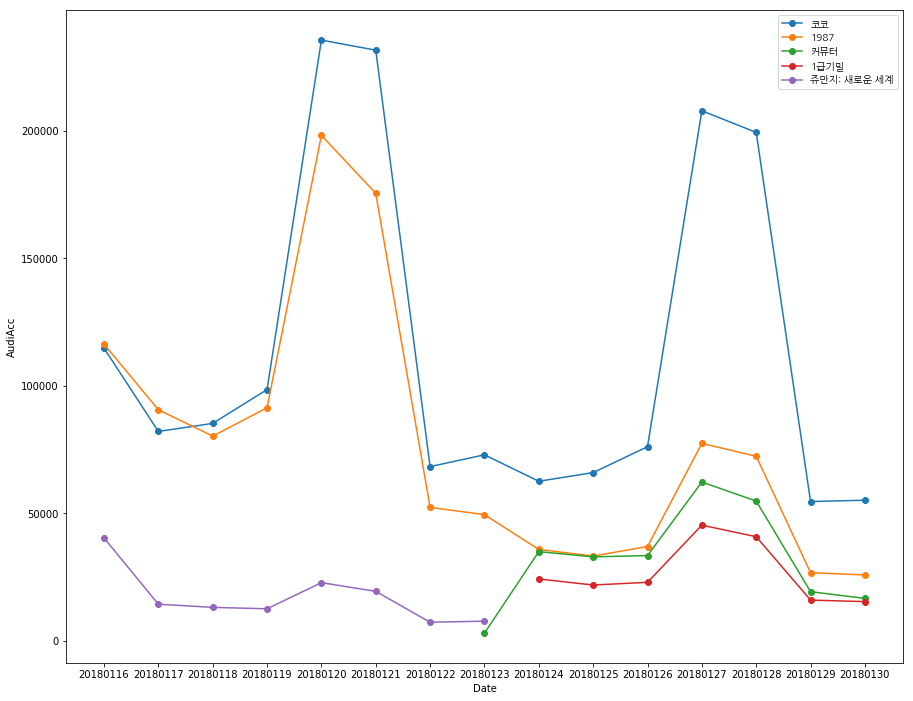

In [19]:
query_and_draw('2018-01-30','2018-01-15')